In [1]:
import jax
import jax.numpy as jnp
from jax.scipy.stats import gaussian_kde
from jax.scipy.optimize import minimize
import numpy as np
import mcmc_infinity as mc
import emcee
import corner

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

seed = 12345

# Target Distribution

Here we try to sample a $d=2$ dimensional Rosenbrock
banana function with log-PDF given by

$$ \log f(x) = -\sum_{i=1}^{d-1} ( 100 (x_{i+1}-x_{i}^2)^2 + (1-x_{i})^2 ) + c, $$

where $c$ is an unknown normalisation constant.

In [2]:
dim = 2

target = mc.test_functions.rosenbrock.Rosenbrock(dim=dim)

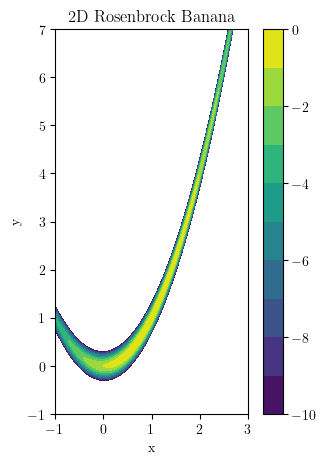

In [3]:
x = np.linspace(-1, 3, 300)
y = np.linspace(-1, 7, 300)
X, Y = np.meshgrid(x, y)
Z = target(np.stack((X,Y), axis=-1))

fig, ax = plt.subplots(figsize=(4,5))

levels = np.linspace(-10, 0, 11)
x = ax.contourf(X, Y, Z, levels=levels)
cbar = plt.colorbar(x)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("2D Rosenbrock Banana")
ax.set_aspect('equal')

plt.show()

# Uniform Proposal

Create a uniform proposal distribution with the prior bounds.

In [4]:
bounds = np.array([[-1.0, 3.0], [-1.0, 7.0]])

uniform_proposal = mc.uniform_proposal.UniformProposal(dim, bounds)

Initialise the perfect sampler.

In [5]:
sampler_uniform = mc.sampler.PerfectSampler(target, 
                                            uniform_proposal, 
                                            np.array([[1.]*dim]), 
                                            seed=seed)

Run the perfect sampler. This will be quite slow because the uniform proposal is inefficient; we will explore more efficient KDE proposals below.

In [6]:
T = 2

num_samples = 1000

samples_uniform, T_uniform = sampler_uniform.get_perfect_samples(T, 
                                                                num_samples, 
                                                                return_T=True)

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/christophermoore/miniconda3/envs/mcmc_infinity/lib/python3.13/site-packages/jax/_src/ops/scatter.py:93: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
100%|██████████| 1000/1000 [04:32<00:00,  3.67it/s]


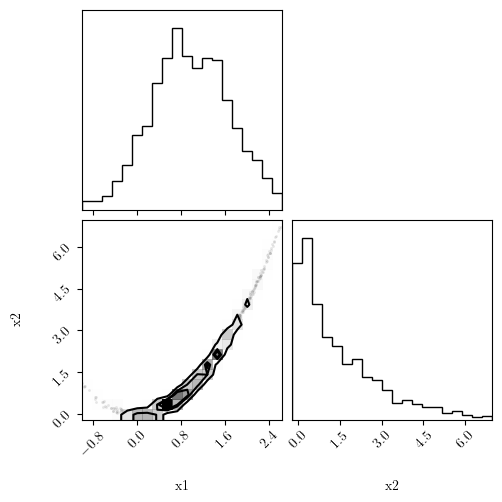

In [8]:
corner.corner(np.array(samples_uniform), ranges=bounds, labels=['x1','x2'])
plt.show()

# KDE Proposal

We will first run an MCMC using the _emcee_ package. 
We use 100 walkers, a burnin of 100, then 10000 iterations. 
Thinning by a factor of 1000 leaves 1000 approximately i.i.d. samples.
These samples do NOT have to be perfect. 

We will use these samples to build our proposal.

Number of samples after burn-in and thinning: 1000


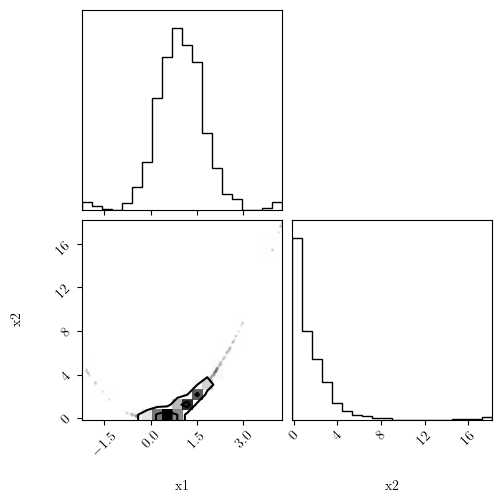

In [10]:
"""
# initialise emcee walker positions uniformly within prior bounds
nwalkers = 100
x0 = np.random.uniform(size=(nwalkers, dim))
x0 = bounds[:,0] + x0 * (bounds[:,1] - bounds[:,0])

# initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, dim, target)

# run burn-in
sampler.run_mcmc(x0, 100, progress=True)
sampler.reset()

# run analysis chains 
sampler.run_mcmc(x0, 10000, progress=True)
print(f"Mean acceptance fraction: {np.mean(sampler.acceptance_fraction):.3f}")
print(f"Mean autocorrelation time: {np.mean(sampler.get_autocorr_time(tol=5)):.3f}")

samples = sampler.get_chain(flat=True, thin=1000)
"""

samples = np.loadtxt("rosenbrock_demo_emcee_samples.txt")
print(f"Number of samples after burn-in and thinning: {len(samples)}")

corner.corner(samples, ranges=bounds, labels=['x1','x2'])

plt.show()

We now build KDEs that we will use as our proposal. 

It is necessary to inflate (i.e. make wider) the KDEs in order for $P/Q$ to have a clear global maximum. Smaller inflation will make the objective function harder to maximise but will yield a more efficient proposal. Conversely, a larger inflation will make the objective function easier to maximise at the cost of a less efficient proposal.

In [11]:
Qkde_small = mc.kde_proposal.KernelDensityEstimateProposal(dim, 
                 inflation_scale=1.2)
Qkde_small.fit(samples)

Qkde_big = mc.kde_proposal.KernelDensityEstimateProposal(dim, 
                 inflation_scale=3.0)
Qkde_big.fit(samples)

We now use the _jax.scipy_ to optimise the objective functions $P/Q$.

In [12]:
sol_small = minimize(lambda x: -(target(x)-Qkde_small.logP(x)[0]), 
               jnp.ones(dim), method="BFGS", tol=1.e-3)

print(f"Solution small: {sol_small.x}, logP: {target(sol_small.x)}")

sol_big = minimize(lambda x: -(target(x)-Qkde_big.logP(x)[0]), 
               jnp.ones(dim), method="BFGS", tol=1.e-3)

print(f"Solution big: {sol_big.x}, logP: {target(sol_big.x)}")

Solution small: [2.31392258 5.34566544], logP: -1.7337408658458646
Solution big: [1.02496879 1.04997407], logP: -0.0006578918128707919


The following cell just does a few manual checks to check that we really have found the global maximum.

In [13]:
x = jnp.array([[float(sol_small.x[0]), float(sol_small.x[1])],
               [1.0, 1.0],
               [bounds[0,0], bounds[1,0]], # lower left
               [bounds[0,0], bounds[1,1]], # upper left
               [bounds[0,1], bounds[1,0]], # lower right
               [bounds[0,1], bounds[1,1]]  # upper right
               ])

print(target(x)-Qkde_small.logP(x))

[ 1.58809054e+00  1.02659411e+00 -3.98702413e+02 -3.59232948e+03
 -9.92757010e+03 -3.98647501e+02]


Initialise the perfect samplers using the KDE proposals.

In [14]:
sampler_kde_small = mc.sampler.PerfectSampler(target, 
                                            Qkde_small, 
                                            jnp.atleast_2d(sol_small.x), 
                                            seed=seed)

sampler_kde_big = mc.sampler.PerfectSampler(target, 
                                            Qkde_big, 
                                            jnp.atleast_2d(sol_big.x), 
                                            seed=seed)

Perform the perfect sampling.

In [15]:
samples_kde_small, T_kde_small = sampler_kde_small.get_perfect_samples(T, 
                                                                num_samples, 
                                                                return_T=True)

samples_kde_big, T_kde_big = sampler_kde_big.get_perfect_samples(T, 
                                                                 num_samples, 
                                                                 return_T=True)

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/christophermoore/miniconda3/envs/mcmc_infinity/lib/python3.13/site-packages/jax/_src/ops/scatter.py:93: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
100%|██████████| 1000/1000 [02:07<00:00,  7.83it/s]


# Plotting

This plot compares the efficieny of the three perfect sampling runs performed in this notebook. 

The small KDE proposal is the most efficient because (on average) it achives coupling with the smallest values of $T$. Conversely, the uniform proposal is the least effecient because it needs the largest $T$ values (on average) to couple.

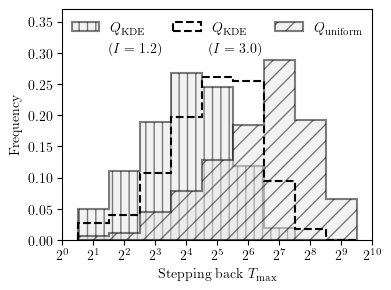

In [16]:
fig, ax = plt.subplots(figsize=(4,3))

ax.hist(jnp.log2(T_kde_small), histtype='stepfilled', alpha=0.5, density=True,
        color='0.9', edgecolor='k', linewidth=1.5, hatch='||',
        bins=0.5+np.arange(0, 10), label=r'$Q_{\rm KDE}$')
ax.text(1.5, 0.3, r"$(I=1.2)$")

ax.hist(jnp.log2(T_kde_big), histtype='step', density=True,
        color='black', linestyle='--', linewidth=1.5,
        bins=0.5+np.arange(0, 10), label=r'$Q_{\rm KDE}$')
ax.text(4.75, 0.3, r"$(I=3.0)$")

ax.hist(jnp.log2(T_uniform), histtype='stepfilled', alpha=0.5, density=True,
        color='0.9', edgecolor='k', linewidth=1.5, hatch='//',
        bins=0.5+np.arange(0, 10), label=r'$Q_{\rm uniform}$')

ax.set_xticks(np.arange(0, 11))
ax.set_xlim(0, 10)
ax.set_ylim(0, 0.37)
ax.set_xticklabels([r"$2^{"+str(i)+"}$" for i in np.arange(0, 11)])

ax.set_xlabel(r"Stepping back $T_{\rm max}$")
ax.set_ylabel("Frequency")

ax.legend(loc='upper center', ncols=3, labelspacing=0,  
          handlelength=2, frameon=False)

plt.show()

This plot demonstrates the binary stepping back approach to achieve coupling.

[  1.58809054  -6.67816859 -22.67816859  -5.17816859]


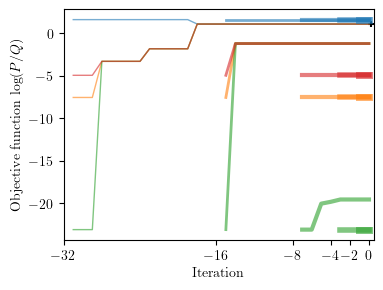

In [22]:
initial_positions = np.array([[float(sol_small.x[0]), float(sol_small.x[1])],
                            [0.0, 0.3],
                            [2.0, 4.5],
                            [-0.5,0.0]])

print(target(initial_positions) - Qkde_small.logP(initial_positions)[0])

colors=['C0', 'C1', 'C2', 'C3']

sampler_demo = mc.sampler.PerfectSampler(target, 
                                        Qkde_small, 
                                        initial_positions,
                                        seed=seed)

_, chains = sampler_demo.get_perfect_sample(2, show_all_output=True)

fig, ax = plt.subplots(figsize=(4,3))

num_walkers = len(initial_positions)

lw = [1, 2, 3, 4, 5]
alpha = [1.0, 0.3, 0.25, 0.2, 0.15]

for c, chain in enumerate(chains[::-1]):
    for w in range(num_walkers):
        if True:
            PQ = target(chain[w]) - Qkde_small.logP(chain[w])
            iter = np.arange(1-len(PQ),1)
            ax.plot(iter, PQ, color=colors[w], lw=1+c, alpha=0.6)
        else:
            pass
        

ax.set_xlim(-32, 0.5)
ax.set_xticks([-32,-16, -8, -4, -2, 0])

y = target(chains[-1][0][-1]) - Qkde_small.logP(chains[-1][0][-1])
ax.scatter([0.25], [y], s=15, marker='+', color='k', alpha=1)

ax.set_xlabel(r"Iteration")
ax.set_ylabel(r"Objective function $\log(P/Q)$")

plt.show()

Finally, this plot shows the target distribution, with some samples overlaid.

The colored square markers show the starting locations of the chains in the above binary stepping back plot with matching colors.

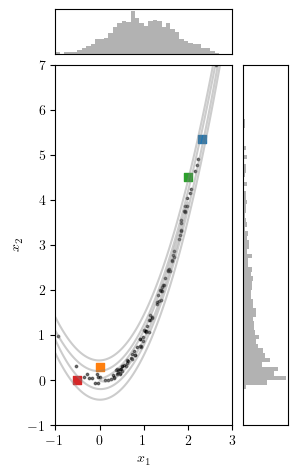

In [20]:
import matplotlib.gridspec as gridspec

bin_width = 0.1

# Custom sizes for rows and columns
widths = [4, 1]     # Column 0 and 1 widths
heights = [1, 8]    # Row 0 and 1 heights

fig = plt.figure(figsize=(0.6*5, 0.6*9))
gs = gridspec.GridSpec(2, 2, 
                       width_ratios=widths, height_ratios=heights, 
                       wspace=0.1, hspace=0.05)

# Lower left corner (row=1, col=0)
ax00 = fig.add_subplot(gs[1, 0])
ax00.contour(X, Y, Z, levels=[-20, -5, -1], colors=['gray'], 
             linestyles=['-'], alpha=0.4)
ax00.scatter(samples_uniform[0:100,0], samples_uniform[0:100,1], 
             s=3, color='k', alpha=0.5)
ax00.set_xlim(bounds[0])
ax00.set_ylim(bounds[1])
ax00.set_xlabel(r'$x_1$')
ax00.set_ylabel(r'$x_2$')
ax00.set_xticks(np.arange(bounds[0,0], bounds[0,1]+1,1))
ax00.set_yticks(np.arange(bounds[1,0], bounds[1,1]+1,1))

for m in range(4):
    ax00.scatter(initial_positions[m,0], initial_positions[m,1], 
                 s=30, color=colors[m], alpha=1, marker='s')

# Lower right (row=1, col=1)
ax01 = fig.add_subplot(gs[1, 1], sharey=ax00)
counts, bins = np.histogram(samples_uniform[:,1],
                            bins=np.arange(bounds[1,0], bounds[1,1], bin_width))
bin_centers = 0.5 * (bins[:-1] + bins[1:])
ax01.barh(bin_centers, counts, height=(bins[1] - bins[0]), 
          color='gray', alpha=0.6)

# Upper left (row=0, col=0)
ax10 = fig.add_subplot(gs[0, 0], sharex=ax00)
counts, bins = np.histogram(samples_uniform[:,0], 
                            bins=np.arange(bounds[0,0], bounds[0,1], bin_width))
bin_centers = 0.5 * (bins[:-1] + bins[1:])
ax10.bar(bin_centers, counts, width=(bins[1] - bins[0]), 
         color='gray', alpha=0.6)

# Hide all ticks and labels on upper-left and lower-right
for ax in [ax10, ax01]:
    ax.tick_params(axis='both', which='both',
                   bottom=False, left=False, labelbottom=False, labelleft=False)

plt.show()